In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# FSS Critical Exponents for Ising S. Carpet

In [ ]:
def get_energy(lattice):
    # suma sobre los vecinos adyacentes
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()

In [3]:
def sierpinski_gasket(lattice, total): #total number of times the process will be repeated  
    for i in range(0, total + 1):
        stepdown = 3**(total - i)
        for x in range(0, 3**i):
          
            # checking for the centremost square
            if x % 3 == 1:
                for y in range(0, 3**i):
                    if y % 3 == 1:
                      
                    # changing its value
                        lattice[y * stepdown:(y + 1)*stepdown, x * stepdown:(x + 1)*stepdown] = 0
                        
    return lattice

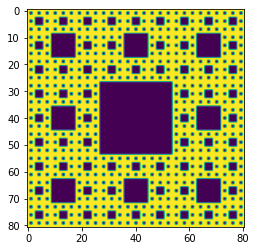

In [4]:
times= 4 #total number of times the process will be repeated
N= 3**times # size of the lattice
flattice_pr= np.ones((N,N))
flattice= sierpinski_gasket(flattice_pr, times)
plt.imshow(flattice)

In [5]:
def metropolis(spin_arr, times, BJ, energy, N):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    #net_energy = np.zeros(times-1)
    
    for t in tqdm (range(0,times-1), desc="Processing"):
        # 2.  Escoger un punto aleatorio y voltear el spin.
        
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        
        while spin_arr[x,y] == 0:
            x = np.random.randint(0,N)
            y = np.random.randint(0,N)
        
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # Calcular cambio en energía
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. Cambiar el estado de acuerdo a las probabilidades
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        #net_energy[t] = energy
        
    n_spins= np.count_nonzero(spin_arr)
    
    spins= net_spins[-10000:].mean()/n_spins
    
    suscp= net_spins[-10000:].std()/n_spins
    
    #energy_mean= net_energy[-100000:].mean()
    #energy_std= net_energy[-100000:].std()
    
    
    return float(spins), float(suscp)

**Objective:** $\beta$/$\nu$ could be found by plotting $m$ vs. $L$ on logarithmic axis. The slope of this plot gave $\beta$/$\nu$.

In [6]:
def get_spin_energy_f(BJs):
    
    n=[5,6,7]
    it=[1000000, 2000000, 5000000]
    spins_= np.zeros(len(n))
    suscp_= np.zeros(len(n))
    #energies_= np.zeros((len(n), len(BJs)))
    #stds_= np.zeros((len(n), len(BJs)))
    
    for j in range(len(n)):
        
        N= 3**n[j] # size of the lattice
        flattice_pr= np.ones((N,N))
        flattice= sierpinski_gasket(flattice_pr, times)
        init_random = np.random.random((N,N))
        random_filter = sierpinski_gasket(init_random, times)
        flattice_p= flattice.copy()
        mask1= random_filter>=0.5 
        flattice_p[mask1] = 1
        mask2 = (random_filter<0.5) & (random_filter!= 0)
        flattice_p[mask2] = -1
        
        #E_means = np.zeros(len(BJs))
        #E_stds = np.zeros(len(BJs))
        
        
        spins, suscp= metropolis(flattice_p, it[j], 0.65, get_energy(flattice_p),N)
            
        spins_[j]= spins
        suscp_[j]= suscp
        
    return spins_, suscp_

In [ ]:
BJs= np.arange(0.5, 2, 0.025)
spins_, suscp_= get_spin_energy_f(BJs)

Processing:  52%|█████▏    | 2616497/4999999 [2:17:44<1:29:59, 441.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing:  58%|█████▊    | 2924550/4999999 [2:29:23<1:18:15, 442.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing:  99%|█████████▊| 4934955/4999999 [4:17:09<04:54, 220.63it/s]  

 https://books.google.com.co/books?hl=es&lr=&id=yRU7AAAAQBAJ&oi=fnd&pg=PP1&dq=finite+size+scaling+analysis&ots=ZKwGbslgWC&sig=Czyf7pjN9zuqTn3wgNwb06htMSQ#v=onepage&q=finite%20size%20scaling%20analysis&f=false